# 模型训练（数据并行）

## 一、单机单卡训练  
1.判断GPU是否可用：torch.cuda.is_available()  // torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
2.设备限制：命令行：CUDA_VISIBLE_DEVICE='0, 1, 3' python xx.py [用013显卡]  代码中：os.environ[CUDA_VISIBLE_DEVICE] = '0'   
3.模型拷贝：model.cuda()  
4.数据拷贝：data = data.cuda()  
5.模型保存: torch.save  
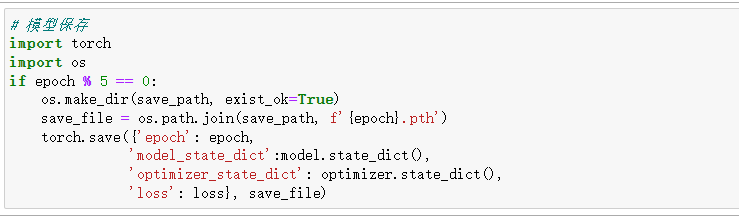
6.模型加载：torch.load(file_pth, map_location=torch.device('cuda'))  
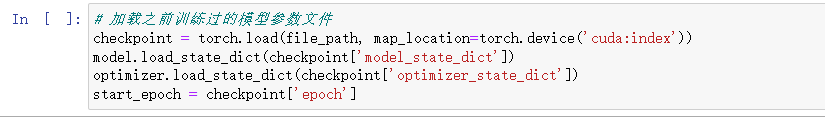

## 二、 单机多卡训练

1.检测GPU数量：torch.cuda.device_count() 
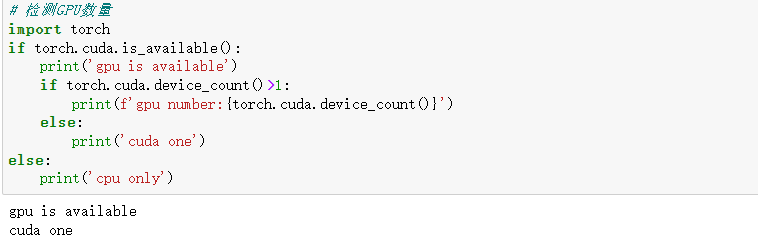
2.限制具体使用的GPU：os.environ[CUDA_VISIBLE_DEVICE]='要使用的GPU编号'  
3.拷贝模型：torch.nn.DataParallel  
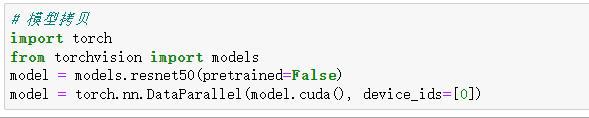
4.模型保存：需要调用model.modules.state_dict()  
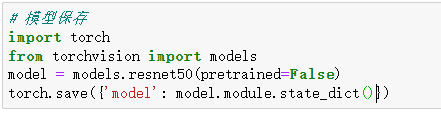
5.模型加载：torch.load(file_path, map_location)与单机单卡一致    
6.注意事项：batch_size设置为所有gpu上的和  
7.缺点：单进程，效率慢；不支持多机训练；不支持模型并行

## 三、单机多卡及多机多卡训练2

#### 1.torch.nn.parallel.DistributedDataParallel(推荐)

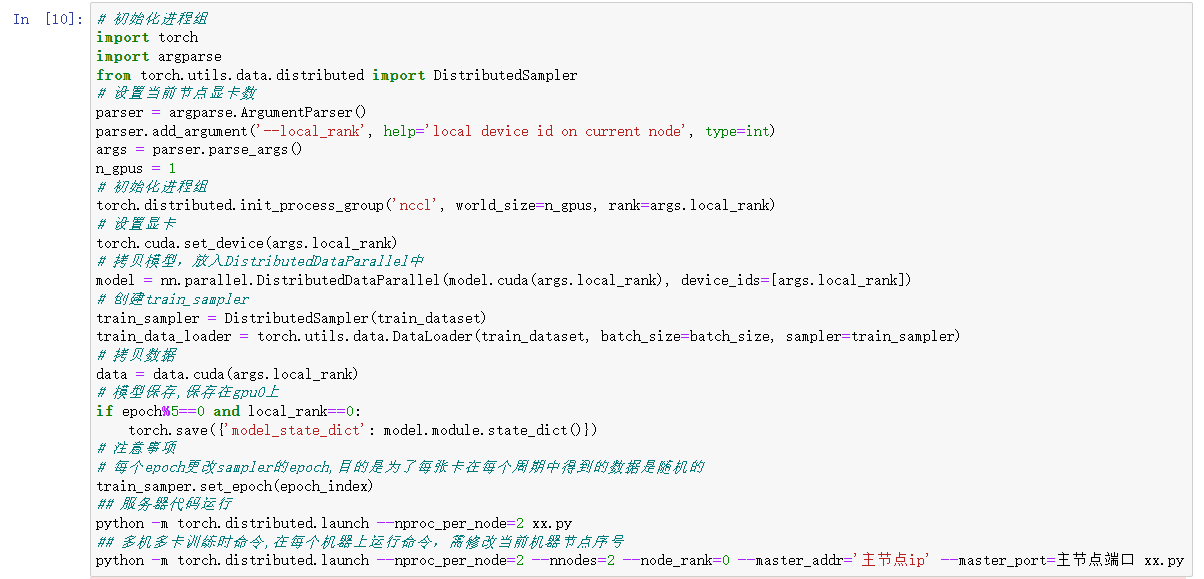

In [10]:
# 初始化进程组
import torch
import argparse
from torch.utils.data.distributed import DistributedSampler
# 设置当前节点显卡数
parser = argparse.ArgumentParser()
parser.add_argument('--local_rank', help='local device id on current node', type=int)
args = parser.parse_args()
n_gpus = 1
# 初始化进程组
torch.distributed.init_process_group('nccl', world_size=n_gpus, rank=args.local_rank)
# 设置显卡
torch.cuda.set_device(args.local_rank)
# 拷贝模型，放入DistributedDataParallel中
model = nn.parallel.DistributedDataParallel(model.cuda(args.local_rank), device_ids=[args.local_rank])
# 创建train_sampler
train_sampler = DistributedSampler(train_dataset)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
# 拷贝数据
data = data.cuda(args.local_rank)
# 模型保存,保存在gpu0上
if epoch%5==0 and local_rank==0:
    torch.save({'model_state_dict': model.module.state_dict()})
# 注意事项
# 每个epoch更改sampler的epoch,目的是为了每张卡在每个周期中得到的数据是随机的
train_samper.set_epoch(epoch_index)
## 服务器代码运行
python -m torch.distributed.launch --nproc_per_node=2 xx.py
## 多机多卡训练时命令,在每个机器上运行命令，需修改当前机器节点序号
python -m torch.distributed.launch --nproc_per_node=2 --nnodes=2 --node_rank=0 --master_addr='主节点ip' --master_port=主节点端口 xx.py

usage: ipykernel_launcher.py [-h] [--local_rank LOCAL_RANK]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\xiaoqiang\AppData\Roaming\jupyter\runtime\kernel-3c806f7a-44a3-4528-9e7e-85f56fb7113b.json


SystemExit: 2

E:\anaconda\envs\pytorch-gpu\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
exit